In [2]:
import ROOT
from ROOT import gROOT, TCanvas, TF1, TFile, TTree, gRandom, TH1F

from ROOT import RooRealVar, RooFormulaVar, RooVoigtian, RooChebychev, RooArgList, \
                 RooArgSet, RooAddPdf, RooDataSet, RooCategory, RooSimultaneous, \
                 RooBreitWigner, RooCBShape, RooFFTConvPdf, RooGaussian,RooExponential, \
                 RooBinning, kRed, kBlue, kDotted,TString,RooAbsData, RooPlot, TCut, RooAbsData, RooFit , RooStats               

In [3]:
import sys
sys.path.append('/home/chasenberg/repos/')
from dopy.dolearn.sklearn_utils import plot_roc_curve, plot_classifier_output, plot_correlations

/opt/rh/miniconda/envs/py3root6/lib/python3.4/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [4]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import os, sys, time, random
import ROOT 
from ROOT import TTree, TFile

# from root_numpy import root2array, rec2array, array2root

import pandas as pd
import numpy as np
import scipy 
import root_pandas as rp
import root_numpy as ry 

import pandas.core.common as com
from pandas.core.index import Index
from pandas.tools import plotting
from pandas.tools.plotting import scatter_matrix

from tqdm import tqdm_notebook

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.externals import joblib
from sklearn.metrics import classification_report, roc_curve, auc, roc_auc_score

sys.path.append('/home/chasenberg/repos/')
sys.path.append('/home/chasenberg/repos/dopy')
from dopy import * 
from dopy.dolearn.sklearn_utils import plot_roc_curve, plot_classifier_output, plot_correlations
from dopy.dolearn.sklearn_utils import plot_feature_importances, plot_classifier_output, classify_unseen_data
#from dopy.sklearn_utils import plot_bdt_vars
from dopy.doplot.plotting import Plotter, Plot
from dopy.doanalysis.df_utils import add_min_max, add_eta 

Declare data directories and read files
--------------------------------------

In [35]:
#directories and files 
mc_dir = '/fhgfs/users/chasenberg/mc/2015_2016_merged/jpsimumuks/'
mc_file= 'Bd2JpsiKS_random.root'
mc_dir = os.path.join(mc_dir, mc_file)
data_dir = '/fhgfs/users/chasenberg/data/2015_2016_merged/jpsimumuks/'
data_file= 'Bd2JpsiKS_bestPV_sw.root'
data_dir = os.path.join(data_dir, data_file)

In [36]:
#Treename and cut for data
tree_data = 'Bd2JpsiKS'
cut_string_data = 'B0_FitDaughtersConst_M_flat<5450&B0_FitDaughtersConst_M_flat>5200'
#criteria and information for read in mc
cut_string_mc = 'B0_FitDaughtersConst_M_flat<5450&B0_FitDaughtersConst_M_flat>5200'
tree_mc = 'Bd2JpsiKS'

Load data from ROOT files
-------------------------------------------------------

In [37]:
signal_dataframe_wrongPV  = rp.read_root(mc_dir,key=tree_mc,where=cut_string_mc, flatten=False)
signal_dataframe_wrongPV  = signal_dataframe_wrongPV.replace([np.inf, -np.inf], np.nan)
signal_dataframe_wrongPV  = signal_dataframe_wrongPV.dropna()

In [38]:
real_dataframe_wrongPV = rp.read_root(data_dir,key=tree_data,where=cut_string_data, flatten=False)
real_dataframe_wrongPV = real_dataframe_wrongPV.replace([np.inf, -np.inf], np.nan)
real_dataframe_wrongPV = real_dataframe_wrongPV.dropna()
#real_dataframe_wrongPV = pd.concat([real_dataframe_wrongPV_2015])'''

## Plot control variable "pz_pull"


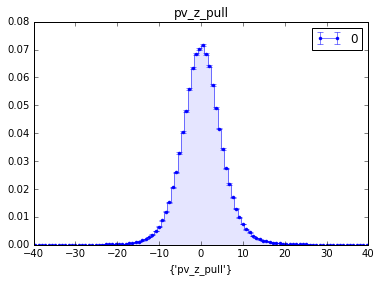

In [39]:
plot_var = ['pv_z_pull']
plot_names = plot_var

plotter = Plotter('/home/chasenberg/plots/wrong_pv/')
plotter.create_plots(signal_dataframe_wrongPV, plot_var)
plotter['pv_z_pull'].set_range(-40,40)#-5000,2000
#plotter['pv_z_pull'].set_log_y()
plotter.plot()

In [40]:
#Rescale Delta_tau
signal_dataframe_wrongPV['pv_z_pull_rescaled'] = signal_dataframe_wrongPV['pv_z_pull'] / np.linalg.norm(signal_dataframe_wrongPV['pv_z_pull'])
signal_dataframe_wrongPV['Delta_TAU_rescaled'] = 1000 * signal_dataframe_wrongPV['Delta_TAU'] / np.linalg.norm(signal_dataframe_wrongPV['Delta_TAU'])

## Plot correlation of pv_z_pull and delta_tau

In [41]:
test = signal_dataframe_wrongPV.query('abs(Delta_TAU)>0.0&abs(pv_z_pull)<30')
test.shape[0]

498692

(913, 79)


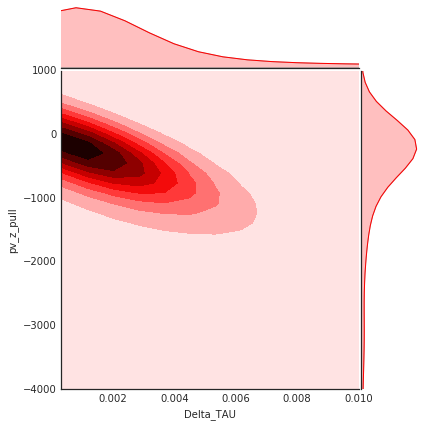

In [42]:
import seaborn as sns; sns.set_style('white')


#abs(Delta_TAU)>0.0006&abs(pv_z_pull)>20&abs(pv_z_pull)<60&abs(pv_z_pull)<30&
test = signal_dataframe_wrongPV.query('Delta_TAU<1&Delta_TAU>0.0003')#.sample(10000)

y_lim = (-4000,1000)
x_lim = (0.0003,0.01)
g = sns.jointplot(x='Delta_TAU', y='pv_z_pull',data=test,stat_func=None,space=0.05, kind="kde",xlim=x_lim,ylim=y_lim, color="r")
g.savefig("/home/chasenberg/plots/wrong_pv/deltatau_vs_pvzpull.pdf")
print(test.shape)

Declare bdt features and correlation matrix  
---------------------------------------------------------------------------------

In [43]:
bdt_features = [  
       'B0_FitPVConst_IPCHI2_flat', 
       'B0_FitPVConst_chi2_flat',
       'B0_FitPVConst_MinIPCHI2anyPV_flat',
       #'B0_FitPVConst_J_psi_1S_MinIPCHI2anyPV_flat',
       'B0_FitPVConst_J_psi_1S_IPCHI2_flat',
       #'B0_FitPVConst_KS0_IPCHI2_flat',
       #'B0_FitPVConst_KS0_MinIPCHI2anyPV_flat',
       'B0_FitDaughtersConst_KS0_IP_flat',
       'muminus_MINIPCHI2',
       'muplus_MINIPCHI2', 
       'B0_FitPVConst_PV_Z_flat',  
      # 'B0_FitPVConst_Z_flat',
       'B0_FitDaughtersConst_J_psi_1S_min_PT'
]

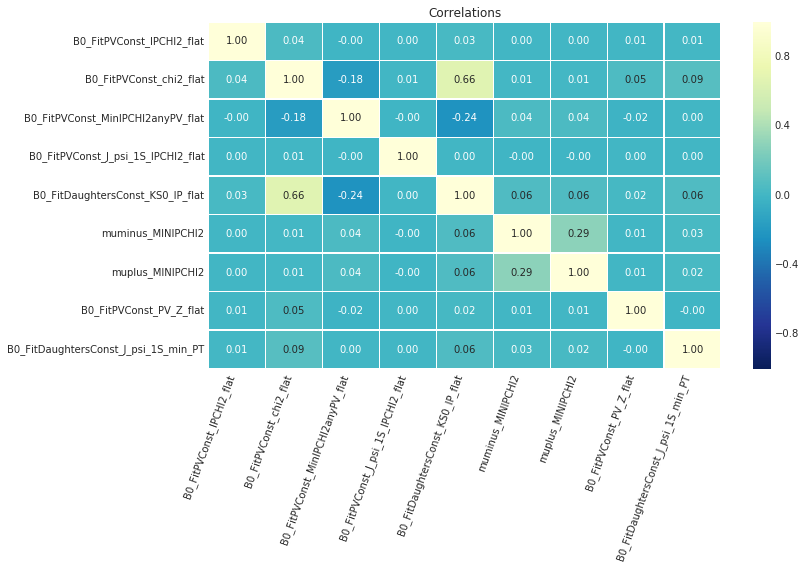

"plot_correlations(signal_dataframe_wrongPV[bdt_features], annot=True, fmt='.2f')\nplt.savefig('/home/chasenberg/plots/wrong_pv/correlation_mc.png')\nplt.show()\nprint('Done!')"

In [44]:
plt.figure(figsize=(12,8))
plot_correlations(signal_dataframe_wrongPV[bdt_features], annot=True, fmt='.2f')
plt.savefig('/home/chasenberg/plots/wrong_pv/correlation_data.png')
plt.show()
plt.figure(figsize=(12,8))
'''plot_correlations(signal_dataframe_wrongPV[bdt_features], annot=True, fmt='.2f')
plt.savefig('/home/chasenberg/plots/wrong_pv/correlation_mc.png')
plt.show()
print('Done!')'''

Plot sWeighted BDT variables against MC
----------------------------------------------------------------------------------

In [45]:
variables = real_dataframe_wrongPV.columns.tolist().remove('signal_sw')

In [46]:
signal_dataframe_wrongPV.columns

Index(['B0_TAGOMEGA_OS', 'B0_TAGDECISION_OS',
       'B0_FitDaughtersConst_status_flat', 'B0_FitDaughtersConst_M_flat',
       'B0_FitDaughtersConst_chi2_flat', 'B0_FitDaughtersConst_IPCHI2_flat',
       'B0_FitDaughtersConst_nDOF_flat', 'B0_FitDaughtersConst_PT_flat',
       'B0_FitDaughtersConst_J_psi_1S_P0_PT_flat',
       'B0_FitDaughtersConst_J_psi_1S_P1_PT_flat',
       'B0_FitDaughtersConst_J_psi_1S_MinIPCHI2anyPV_flat',
       'B0_FitDaughtersConst_J_psi_1S_IPCHI2_flat',
       'B0_FitDaughtersConst_J_psi_1S_IP_flat',
       'B0_FitDaughtersConst_KS0_P1_PT_flat',
       'B0_FitDaughtersConst_KS0_P0_PT_flat',
       'B0_FitDaughtersConst_KS0_P0_IPCHI2_flat',
       'B0_FitDaughtersConst_KS0_P1_IPCHI2_flat',
       'B0_FitDaughtersConst_KS0_decayLength_flat',
       'B0_FitDaughtersConst_KS0_IP_flat', 'B0_FitPVConst_status_flat',
       'B0_FitPVConst_IPCHI2_flat', 'B0_FitPVConst_chi2_flat',
       'B0_FitPVConst_nDOF_flat', 'B0_FitPVConst_tauErr_flat',
       'B0_FitPVConst_tau_

## sWeighted data against mc

In [47]:
for feature in bdt_features:
    print(feature)

B0_FitPVConst_IPCHI2_flat
B0_FitPVConst_chi2_flat
B0_FitPVConst_MinIPCHI2anyPV_flat
B0_FitPVConst_J_psi_1S_IPCHI2_flat
B0_FitDaughtersConst_KS0_IP_flat
muminus_MINIPCHI2
muplus_MINIPCHI2
B0_FitPVConst_PV_Z_flat
B0_FitDaughtersConst_J_psi_1S_min_PT


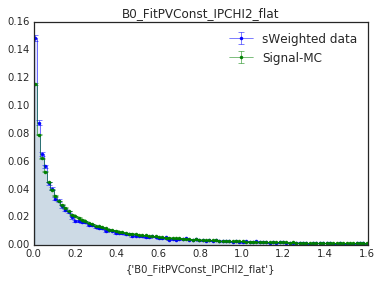

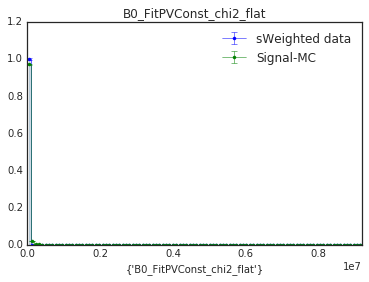

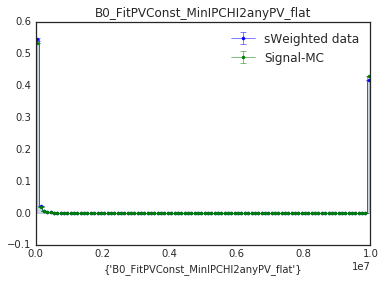

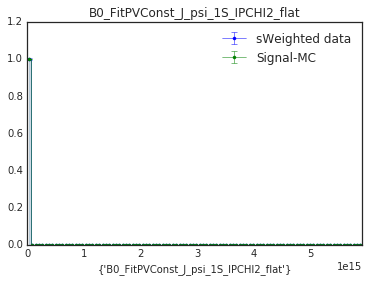

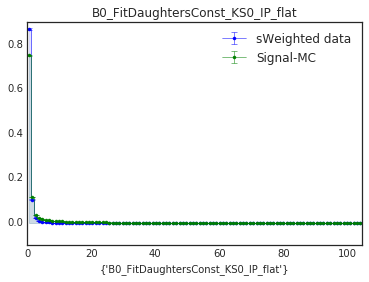

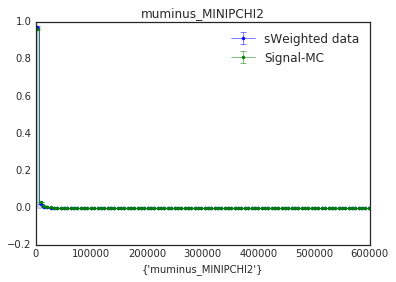

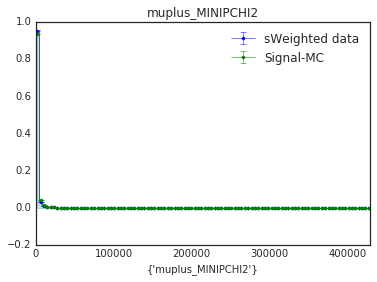

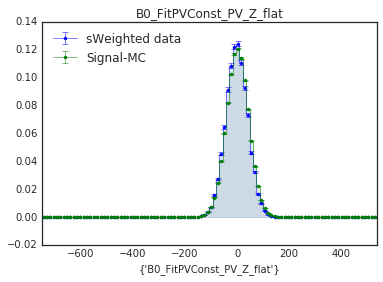

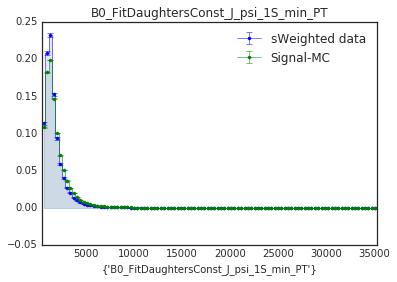

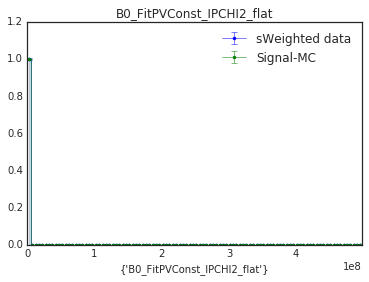

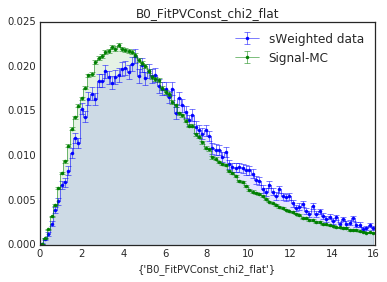

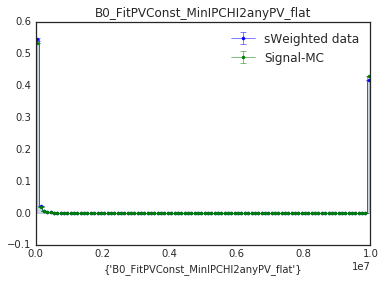

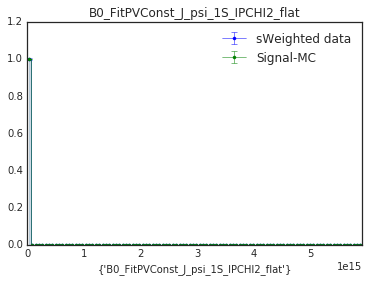

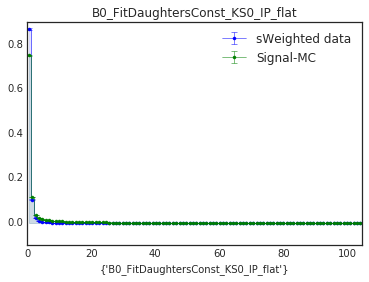

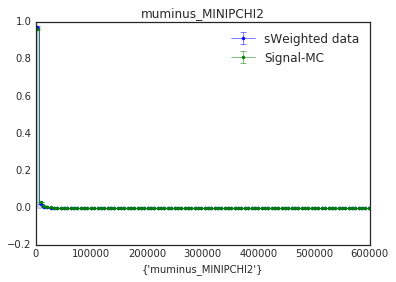

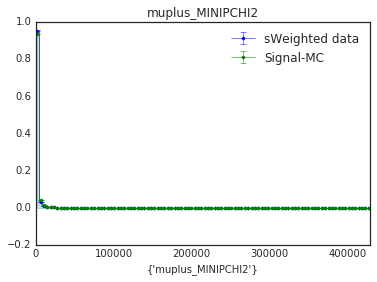

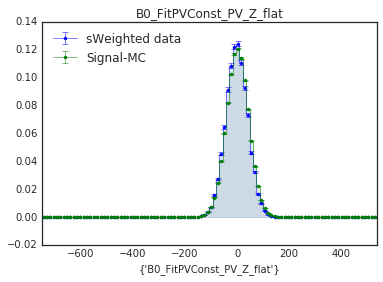

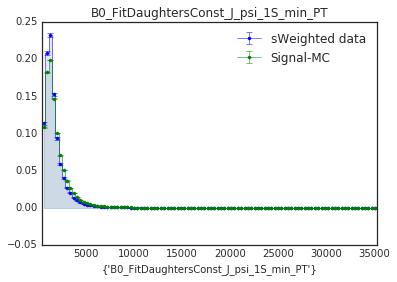

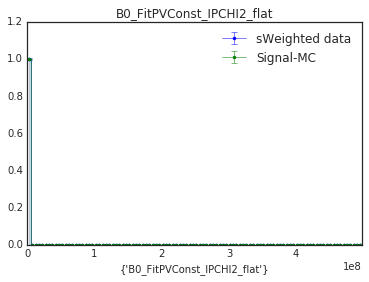

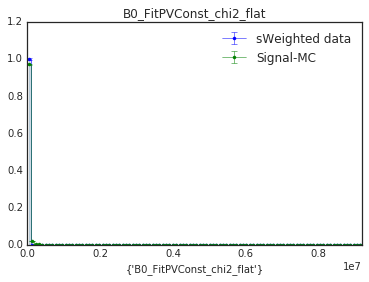

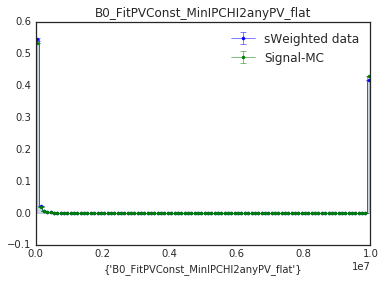

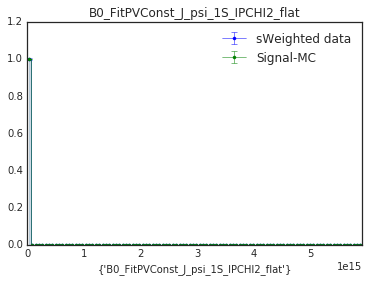

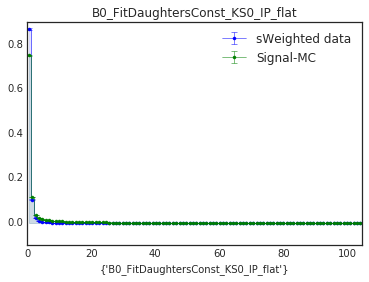

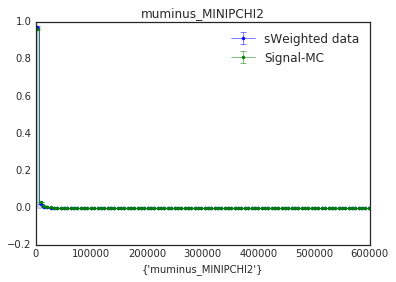

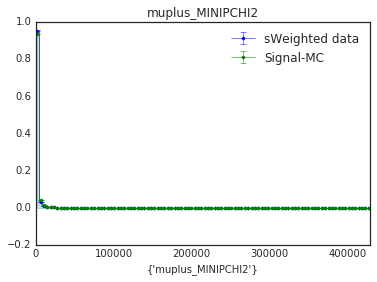

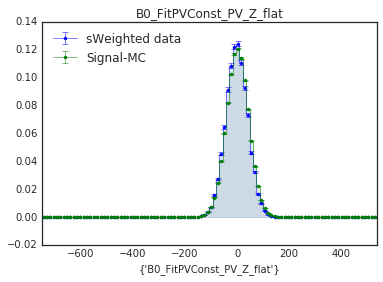

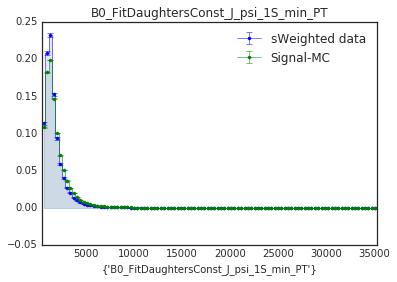

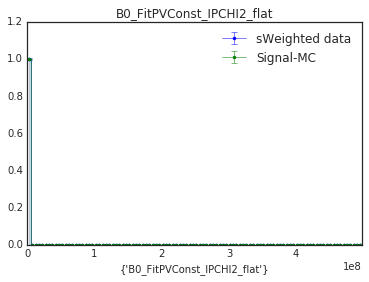

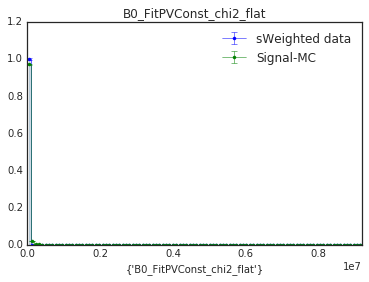

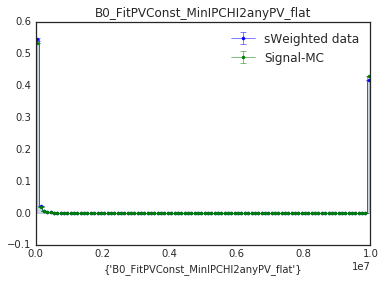

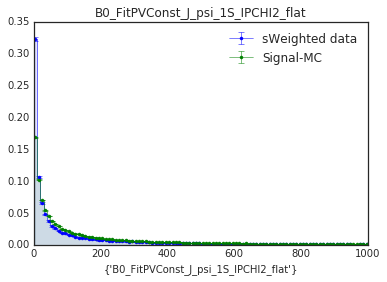

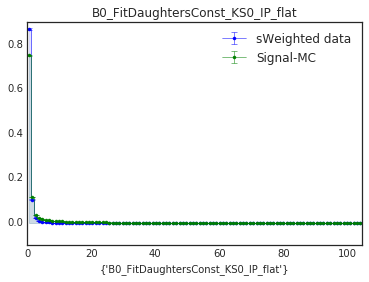

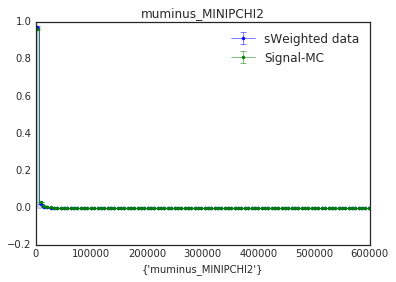

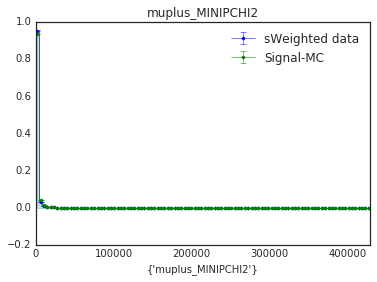

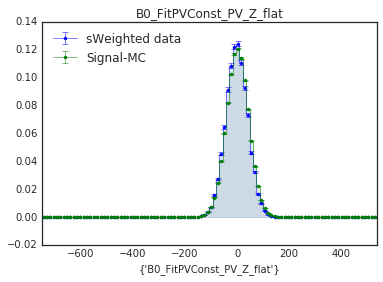

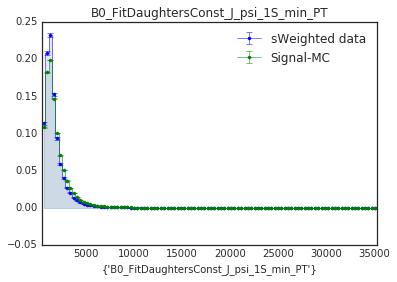

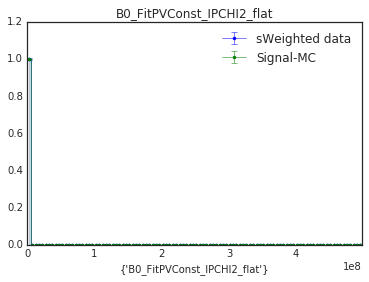

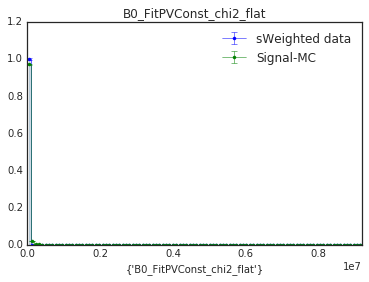

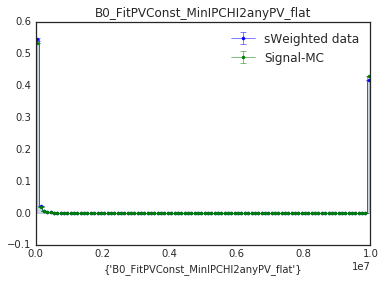

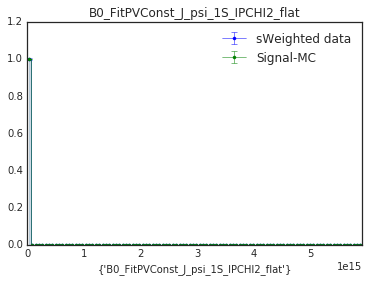

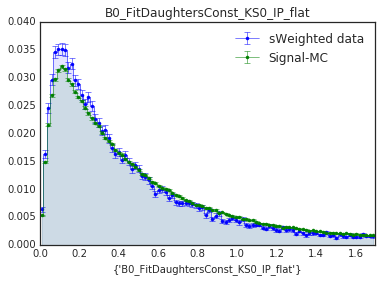

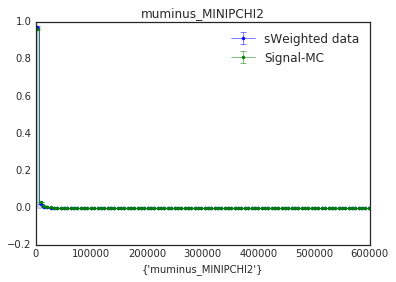

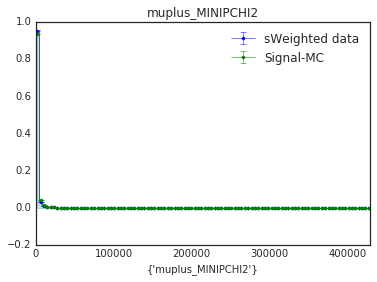

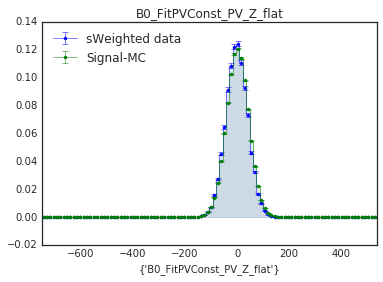

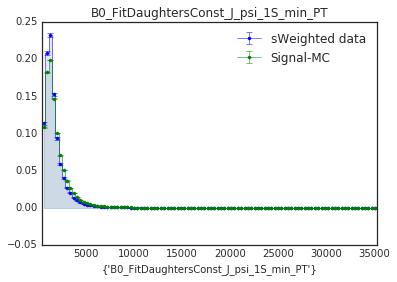

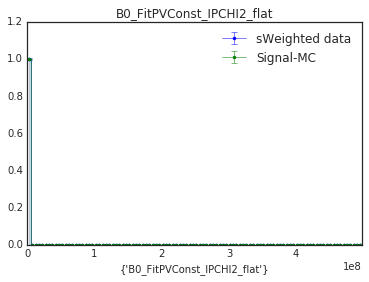

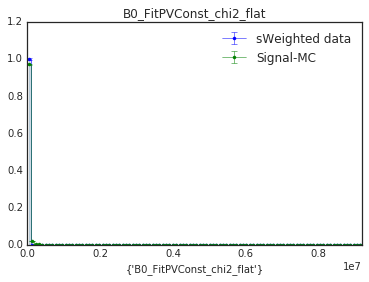

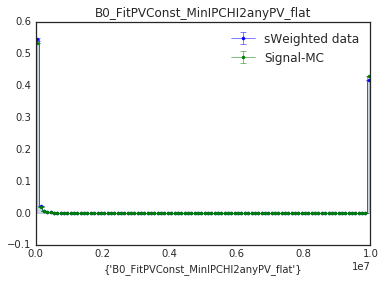

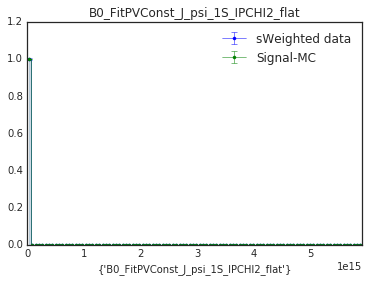

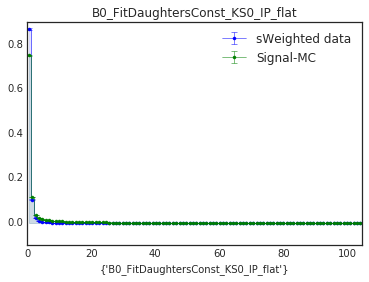

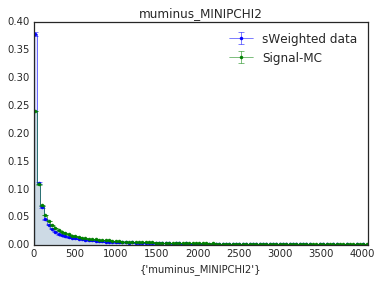

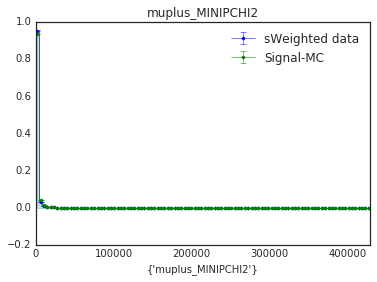

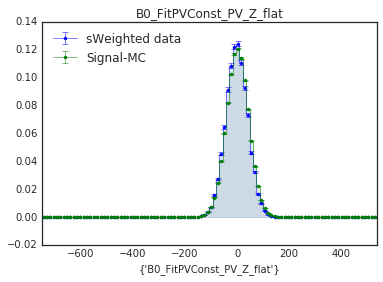

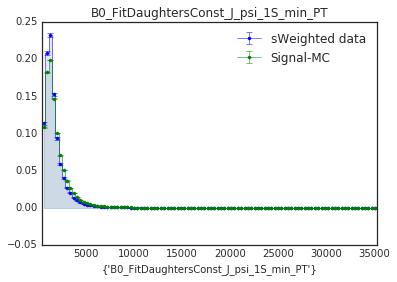

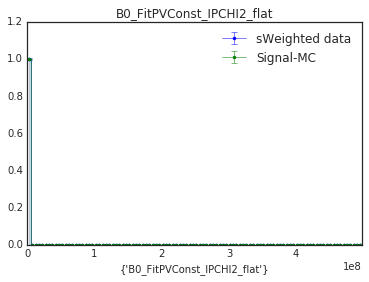

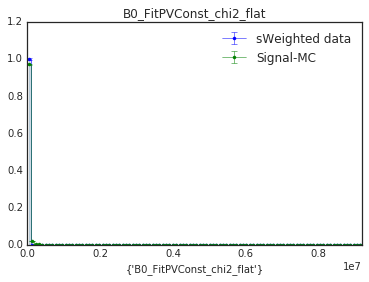

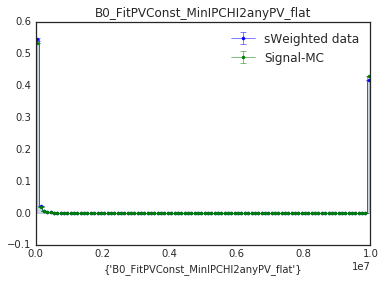

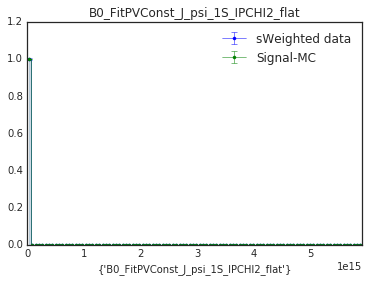

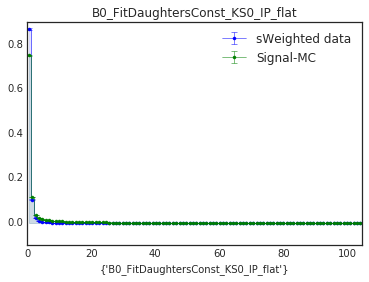

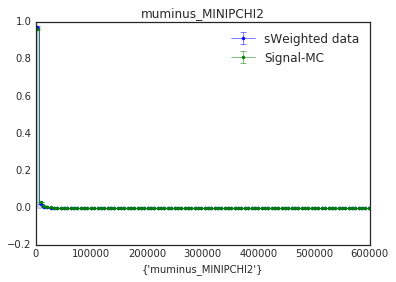

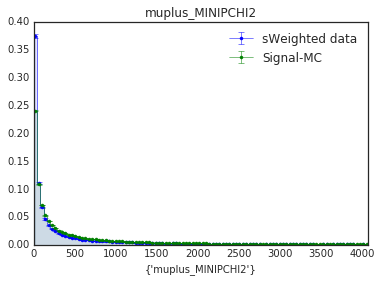

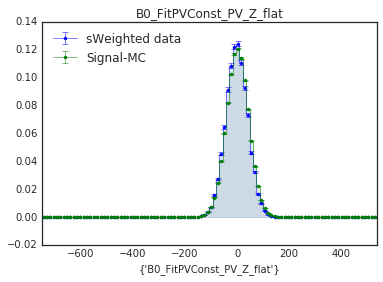

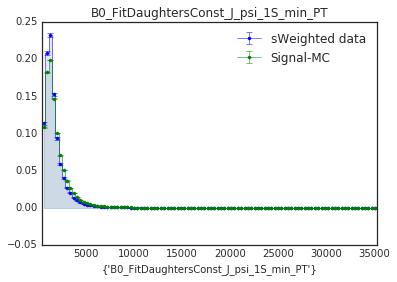

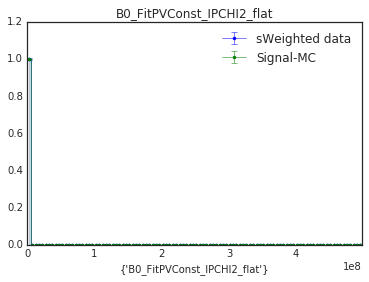

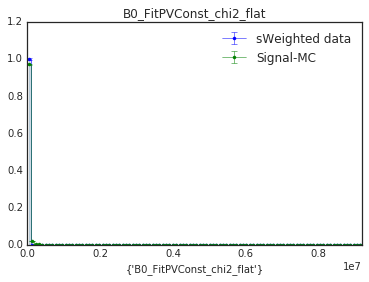

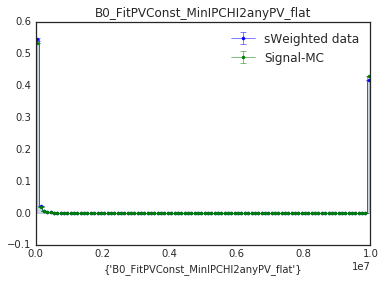

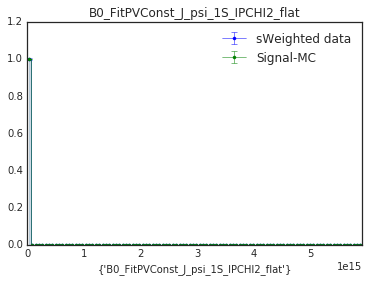

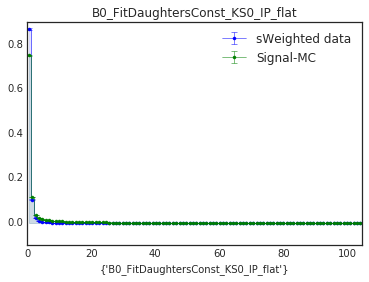

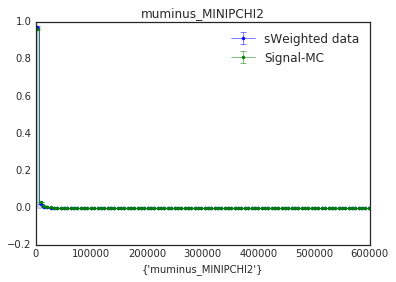

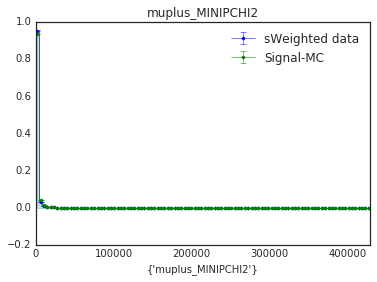

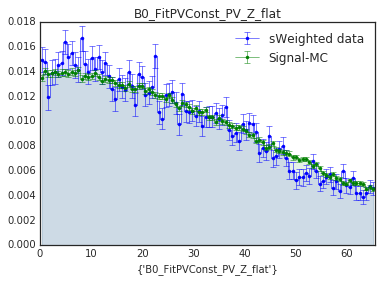

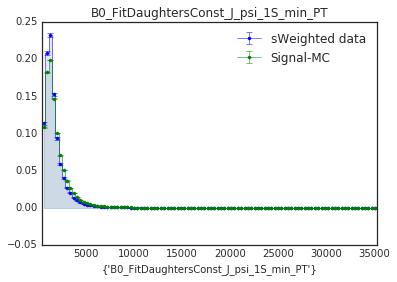

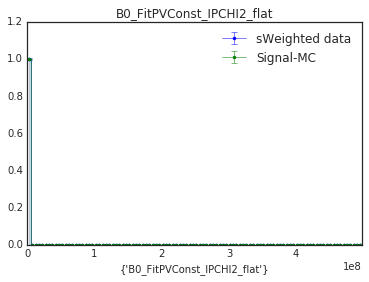

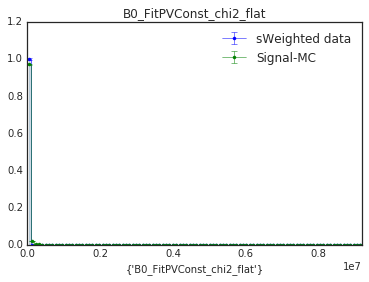

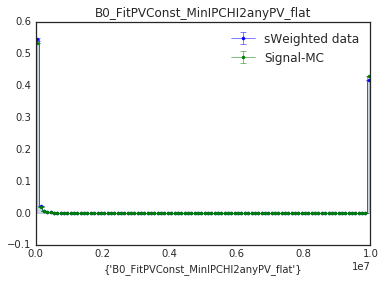

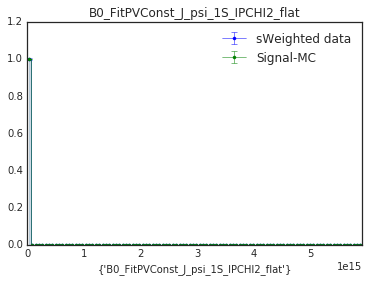

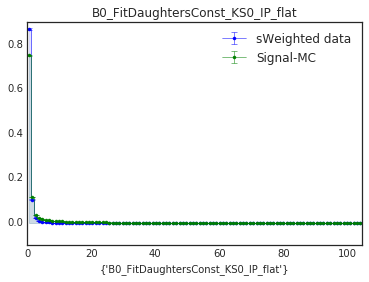

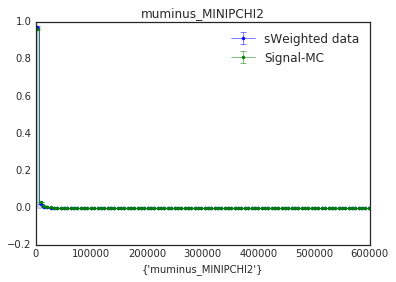

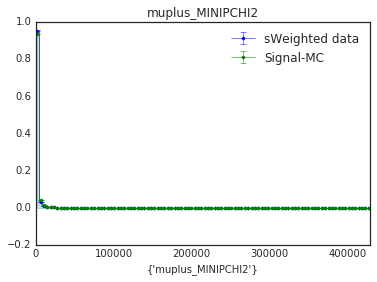

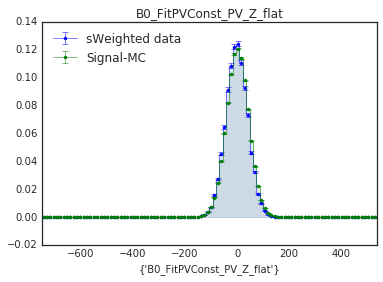

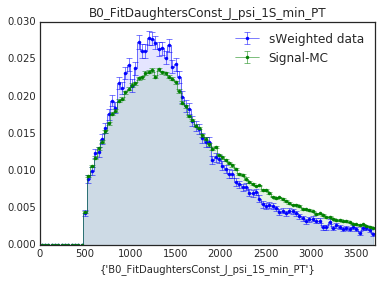

In [48]:
#Check bdt-variables 
mc_weight = np.ones(signal_dataframe_wrongPV.shape[0])
signal_dataframe_wrongPV['mc_weight'] = mc_weight

for feature in bdt_features:
    plotter = Plotter('/home/chasenberg/plots/wrong_pv/mc_agreement/')
    plotter.create_plots([real_dataframe_wrongPV,signal_dataframe_wrongPV], bdt_features, weightvars=['signal_sw','mc_weight']
    ,component_labels=['sWeighted data','Signal-MC'])
    plotter[feature].set_range(0,real_dataframe_wrongPV[feature].quantile(0.95))
    #plotter[feature].set_range(0,20)
    plotter.plot()

Train GradienBoost classifier
====================================================================

In [49]:
correct_pvs = signal_dataframe_wrongPV.query('abs(pv_z_pull)<20')
incorrect_pvs = signal_dataframe_wrongPV.query('abs(pv_z_pull)>20')
flags = np.array([1]*len(correct_pvs)+[0]*len(incorrect_pvs))
dataframe = pd.concat([correct_pvs,incorrect_pvs])

In [50]:
correct_pvs.shape, incorrect_pvs.shape,dataframe.shape

((496785, 80), (4788, 80), (501573, 80))

In [51]:
#Apply Track Type cuts piminus_TRACK_Type

In [52]:
'''train_dataframe, test_dataframe, train_flags, test_flags = train_test_split(
                                                            dataframe[bdt_features], flags, test_size=0.5, random_state=42)
classifier = GradientBoostingClassifier(max_depth=3, verbose=1,n_estimators=200,learning_rate=0.03)
classifier.fit(train_dataframe, train_flags)'''

'train_dataframe, test_dataframe, train_flags, test_flags = train_test_split(\n                                                            dataframe[bdt_features], flags, test_size=0.5, random_state=42)\nclassifier = GradientBoostingClassifier(max_depth=3, verbose=1,n_estimators=200,learning_rate=0.03)\nclassifier.fit(train_dataframe, train_flags)'

In [53]:
train_dataframe, test_dataframe, train_flags, test_flags = train_test_split(
                                                            dataframe[bdt_features], flags, test_size=0.5, random_state=42)
classifier = GradientBoostingClassifier(max_depth=3, verbose=1,n_estimators=200,learning_rate=0.03)
classifier.fit(train_dataframe, train_flags)

      Iter       Train Loss   Remaining Time 
         1           0.1056           56.67s
         2           0.1042           56.35s
         3           0.1030           56.02s
         4           0.1020           55.76s
         5           0.1011           55.93s
         6           0.1004           56.01s
         7           0.0997           56.04s
         8           0.0991           56.30s
         9           0.0986           56.18s
        10           0.0982           55.88s
        20           0.0951           53.65s
        30           0.0935           50.55s
        40           0.0925           47.53s
        50           0.0917           44.29s
        60           0.0909           41.39s
        70           0.0903           38.52s
        80           0.0898           35.71s
        90           0.0891           32.84s
       100           0.0887           29.96s
       200           0.0863            0.00s


GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.03, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=200, presort='auto', random_state=None,
              subsample=1.0, verbose=1, warm_start=False)

In [54]:
dataframe.shape

(501573, 80)

Classifier performance
-----------------------

In [55]:
classifier.score(test_dataframe, test_flags)

0.99046601299110404

In [56]:
importances = classifier.feature_importances_
print("Features sorted by their score:" )
importances_sorted = sorted(zip(importances, dataframe.columns), reverse=True)
for val,name in importances_sorted:
    print('{}: {:.4f}'.format(name, val))

Features sorted by their score:
B0_FitDaughtersConst_status_flat: 0.3367
B0_TAGOMEGA_OS: 0.2446
B0_FitDaughtersConst_nDOF_flat: 0.0859
B0_FitDaughtersConst_J_psi_1S_P0_PT_flat: 0.0689
B0_FitDaughtersConst_IPCHI2_flat: 0.0630
B0_TAGDECISION_OS: 0.0630
B0_FitDaughtersConst_PT_flat: 0.0612
B0_FitDaughtersConst_M_flat: 0.0494
B0_FitDaughtersConst_chi2_flat: 0.0274


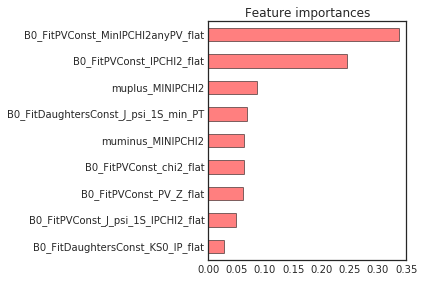

In [57]:
#Plot feature importances 
plot_feature_importances(classifier,dataframe[bdt_features])
plt.savefig('/home/chasenberg/plots/wrong_pv/feature_importance.png', bbox_inches='tight')

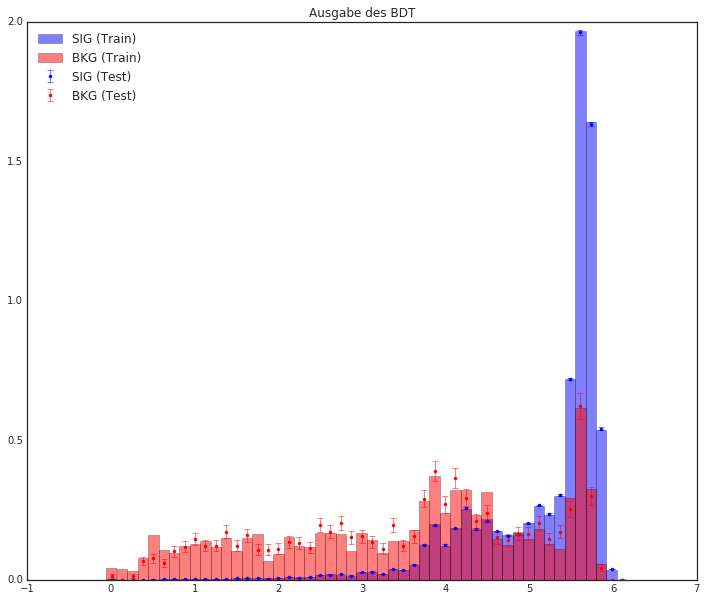

In [58]:
plt.figure(figsize=(12,10))
plot_classifier_output(classifier, train_dataframe, train_flags, test_dataframe, test_flags, title='Ausgabe des BDT',bins=50)
plt.savefig('/home/chasenberg/plots/wrong_pv/overtraining.pdf')
plt.show()


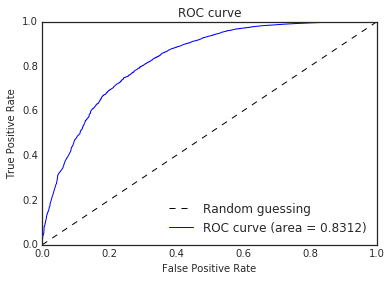

In [59]:
plot_roc_curve(classifier, test_dataframe, test_flags)
plt.savefig('/home/chasenberg/plots/wrong_pv/roc_curve.png')




Classify unseen Data
============================================

In [60]:
#apply classifier to data and MC
classify_unseen_data([classifier], dataframe, bdt_features, 'BDTresponse_wrongPV')

Check efficiencies of classifier cuts
-------------------------------

In [61]:
cut = 'BDTresponse_wrongPV>4'
efficiency = dataframe.query(cut).shape[0] / dataframe.shape[0]
print('The efficiency of the cut is:')
print(efficiency,dataframe.shape[0])
#compare to best PV selection
efficiency = dataframe.query('idxPV==0').shape[0] / dataframe.shape[0]
print('The efficiency of the bestPV selection is:')
print(efficiency,dataframe.shape[0])

The efficiency of the cut is:
0.902231579451047 501573
The efficiency of the bestPV selection is:
0.8858889932273069 501573


In [62]:
dataframe.to_root('/fhgfs/users/chasenberg/mc/2015_2016_merged/jpsimumuks/Bd2JpsiKS_pv_selected.root',key='Bd2JpsiKS')

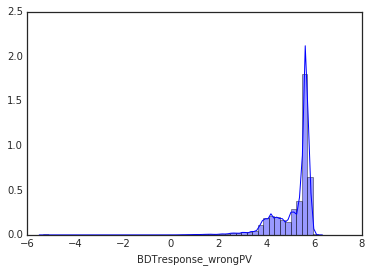

In [63]:
import seaborn as sns
sns.distplot(dataframe['BDTresponse_wrongPV'])

In [64]:
dataframe.columns

Index(['B0_TAGOMEGA_OS', 'B0_TAGDECISION_OS',
       'B0_FitDaughtersConst_status_flat', 'B0_FitDaughtersConst_M_flat',
       'B0_FitDaughtersConst_chi2_flat', 'B0_FitDaughtersConst_IPCHI2_flat',
       'B0_FitDaughtersConst_nDOF_flat', 'B0_FitDaughtersConst_PT_flat',
       'B0_FitDaughtersConst_J_psi_1S_P0_PT_flat',
       'B0_FitDaughtersConst_J_psi_1S_P1_PT_flat',
       'B0_FitDaughtersConst_J_psi_1S_MinIPCHI2anyPV_flat',
       'B0_FitDaughtersConst_J_psi_1S_IPCHI2_flat',
       'B0_FitDaughtersConst_J_psi_1S_IP_flat',
       'B0_FitDaughtersConst_KS0_P1_PT_flat',
       'B0_FitDaughtersConst_KS0_P0_PT_flat',
       'B0_FitDaughtersConst_KS0_P0_IPCHI2_flat',
       'B0_FitDaughtersConst_KS0_P1_IPCHI2_flat',
       'B0_FitDaughtersConst_KS0_decayLength_flat',
       'B0_FitDaughtersConst_KS0_IP_flat', 'B0_FitPVConst_status_flat',
       'B0_FitPVConst_IPCHI2_flat', 'B0_FitPVConst_chi2_flat',
       'B0_FitPVConst_nDOF_flat', 'B0_FitPVConst_tauErr_flat',
       'B0_FitPVConst_tau_